In [1]:
"Utility functions"
import numpy as np
import pandas as pd
from scipy import stats
import sdv

# from sdv.datasets.demo import download_demo
# from sdv.metadata import SingleTableMetadata
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity

In [8]:
import warnings 
warnings.filterwarnings('ignore')

## Distribution Estimation 

In [5]:
def detect_distribution(column):
    """
    Detects the distribution that best fits the data in a given column.

    Args:
    - column (pandas.Series): The input column containing numerical data.

    Returns:
    - detected_distribution (str): The name of the detected distribution.
    """
    
    # Removing NaN values from the column
    data = column.dropna()

    # Calculate basic statistics
    mean = data.mean()
    std = data.std()
    skewness = data.skew()

    # Fit different distributions and calculate goodness of fit scores
    distribution_scores = {
        'norm': np.abs(stats.norm.fit(data)[1] - std),
        'beta': np.abs(stats.beta.fit(data)[1] - std),
        'truncnorm': np.abs(stats.truncnorm.fit(data)[1] - std),
        'uniform': np.abs(stats.uniform.fit(data)[1] - std),
        'gamma': np.abs(stats.gamma.fit(data)[1] - std)
    }

    # Fit Gaussian KDE and calculate log-likelihood
    kde = KernelDensity(bandwidth=0.2).fit(data.values.reshape(-1, 1))
    log_likelihood = kde.score_samples(data.values.reshape(-1, 1)).sum()

    distribution_scores['gaussian_kde'] = -log_likelihood

    # Find the distribution with the smallest score
    detected_distribution = min(
        distribution_scores, key=distribution_scores.get)
    print(distribution_scores)
    return detected_distribution

In [6]:
exp_dataset = "pums"
model = "gaussian_copula"
lib = "sdv"

train_df = pd.read_csv(f"../all_sample_datasets/{exp_dataset}.csv")
# train_report = ProfileReport(train_df, title="Real", minimal=False)

# test_df = pd.read_csv(f"../final_outs/{lib}_tabular/{model}/{exp_dataset}/{exp_dataset}_{model}_synthetic_data.csv")
# test_report = ProfileReport(test_df, title="Synthetic", minimal=False)

In [ ]:
train_df = train_df.sample(n=2000)
for col in train_df.columns:
    try:
        print(col, ": ", detect_distribution(train_df[col]))
    except Exception as e:
        print("Failed: ", col)

## Hyperparameter Optimisation 

In [29]:
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
import optuna
from synthcity.benchmark import Benchmarks


from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from sklearn.datasets import load_diabetes

In [30]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
X["target"] = y
X

age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  target  
0   -0.002592  0.019907 -0.017646   151.0  
1   -0.039493 -0.068332 -0.092204    75.0  
2   -0.002592  0.002861 -0.025930   141.0  
3    0.034309  0.022688 -0.009362   206.0  
4   -0.002592 -0.031988 -0.046641   135.0  
..        ...       ...       ...     ...  
437 -0.002592  0.031193  0.007207   178.0  
438  0.034309 -0.018114  0.044485   104.0  
439 -0.011080 -0.046883  0.015491   132.0  
440  0.026560  0.044529 -0.025930   220.0  
441 -0.039493 -0.004222  0.003064    57.0  

[442 rows x 11 columns]

In [31]:
loader = GenericDataLoader(
    X,
    target_column="target",
    sensitive_columns=["sex"],
)
train_loader, test_loader = loader.train(), loader.test()

In [32]:
PLUGIN = "tvae"
plugin_cls = type(Plugins().get(PLUGIN))
plugin_cls

[2023-12-25T01:21:59.239546+0800][38675][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-12-25T01:21:59.243036+0800][38675][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-12-25T01:21:59.244440+0800][38675][CRITICAL] module plugin_great load failed


synthcity.plugins.generic.plugin_tvae.TVAEPlugin

In [33]:
plugin_cls.hyperparameter_space()


[IntegerDistribution(name='n_iter', data=None, random_state=0, marginal_distribution=None, low=100, high=500, step=100),
 CategoricalDistribution(name='lr', data=None, random_state=0, marginal_distribution=None, choices=[0.0001, 0.0002, 0.001]),
 IntegerDistribution(name='decoder_n_layers_hidden', data=None, random_state=0, marginal_distribution=None, low=1, high=5, step=1),
 CategoricalDistribution(name='weight_decay', data=None, random_state=0, marginal_distribution=None, choices=[0.0001, 0.001]),
 CategoricalDistribution(name='batch_size', data=None, random_state=0, marginal_distribution=None, choices=[64, 128, 256, 512]),
 IntegerDistribution(name='n_units_embedding', data=None, random_state=0, marginal_distribution=None, low=50, high=500, step=50),
 IntegerDistribution(name='decoder_n_units_hidden', data=None, random_state=0, marginal_distribution=None, low=50, high=500, step=50),
 CategoricalDistribution(name='decoder_nonlin', data=None, random_state=0, marginal_distribution=None

In [34]:
from synthcity.utils.optuna_sample import suggest_all

trial = optuna.create_study().ask()
params = suggest_all(trial, plugin_cls.hyperparameter_space())
params['n_iter'] = 100  # speed up
params

{'n_iter': 100,
 'lr': 0.0001,
 'decoder_n_layers_hidden': 5,
 'weight_decay': 0.001,
 'batch_size': 512,
 'n_units_embedding': 450,
 'decoder_n_units_hidden': 100,
 'decoder_nonlin': 'leaky_relu',
 'decoder_dropout': 0.09710405548076598,
 'encoder_n_layers_hidden': 3,
 'encoder_n_units_hidden': 450,
 'encoder_nonlin': 'leaky_relu',
 'encoder_dropout': 0.18133582915089536}

In [35]:
plugin = plugin_cls(**params).fit(train_loader)
report = Benchmarks.evaluate(
    [("trial", PLUGIN, params)],
    train_loader,  # Benchmarks.evaluate will split out a validation set
    repeats=1,
    metrics={"detection": ["detection_mlp"]},  # DELETE THIS LINE FOR ALL METRICS
)
report['trial']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]
[2023-12-25T01:23:26.521360+0800][38675][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-12-25T01:23:26.522207+0800][38675][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-12-25T01:23:26.522838+0800][38675][CRITICAL] module plugin_great load failed
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


min       max      mean  stddev    median  \
detection.detection_mlp.mean  0.546875  0.546875  0.546875     0.0  0.546875   

                              iqr rounds errors  durations direction  
detection.detection_mlp.mean  0.0      1      0       0.69  minimize

In [36]:
def objective(trial: optuna.Trial):
    hp_space = Plugins().get(PLUGIN).hyperparameter_space()
    hp_space[0].high = 100  # speed up for now
    params = suggest_all(trial, hp_space)
    ID = f"trial_{trial.number}"
    try:
        report = Benchmarks.evaluate(
            [(ID, PLUGIN, params)],
            train_loader,
            repeats=1,
            metrics={"detection": ["detection_mlp"]},  # DELETE THIS LINE FOR ALL METRICS
        )
    except Exception as e:  # invalid set of params
        print(f"{type(e).__name__}: {e}")
        print(params)
        raise optuna.TrialPruned()
    score = report[ID].query('direction == "minimize"')['mean'].mean()
    # average score across all metrics with direction="minimize"
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=2)
study.best_params

[2023-12-25T01:24:42.149324+0800][38675][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-12-25T01:24:42.150448+0800][38675][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-12-25T01:24:42.150970+0800][38675][CRITICAL] module plugin_great load failed
[2023-12-25T01:24:42.168808+0800][38675][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-12-25T01:24:42.169477+0800][38675][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-12-25T01:24:42.170043+0800][38675][CRITICAL] module plugin_great load failed
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]
[2023-12-25T01:27:12.466600+0800][38675][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 

{'n_iter': 100,
 'lr': 0.0001,
 'decoder_n_layers_hidden': 1,
 'weight_decay': 0.001,
 'batch_size': 512,
 'n_units_embedding': 200,
 'decoder_n_units_hidden': 400,
 'decoder_nonlin': 'tanh',
 'decoder_dropout': 0.050766055391447365,
 'encoder_n_layers_hidden': 3,
 'encoder_n_units_hidden': 450,
 'encoder_nonlin': 'tanh',
 'encoder_dropout': 0.12424695362214029}

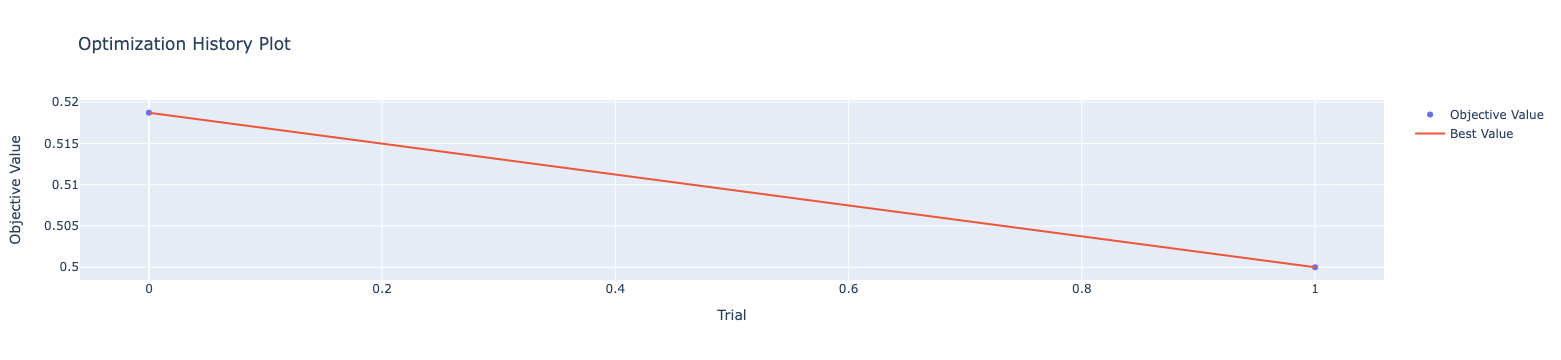

In [37]:
plot_optimization_history(study)

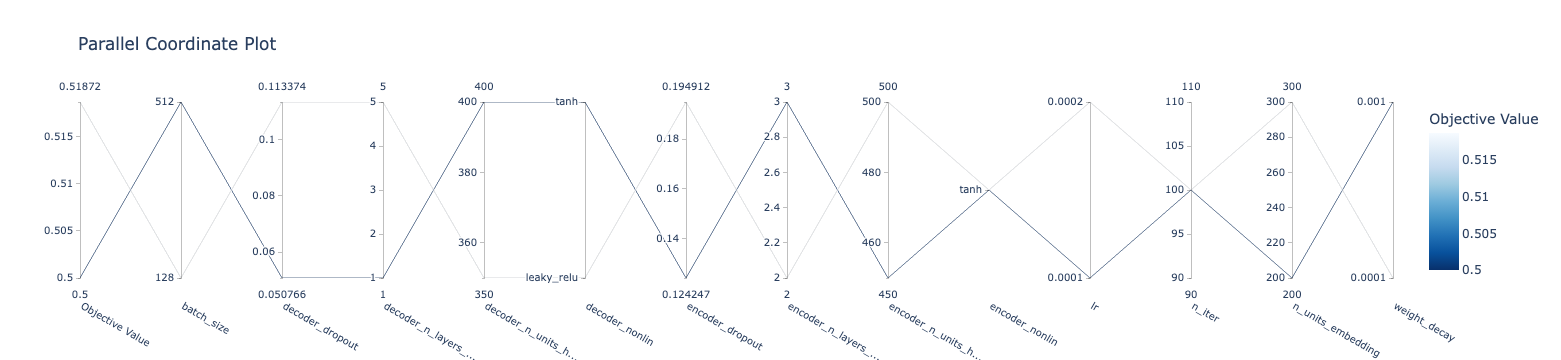

In [38]:
# Visualize high-dimensional parameter relationships. 
plot_parallel_coordinate(study)

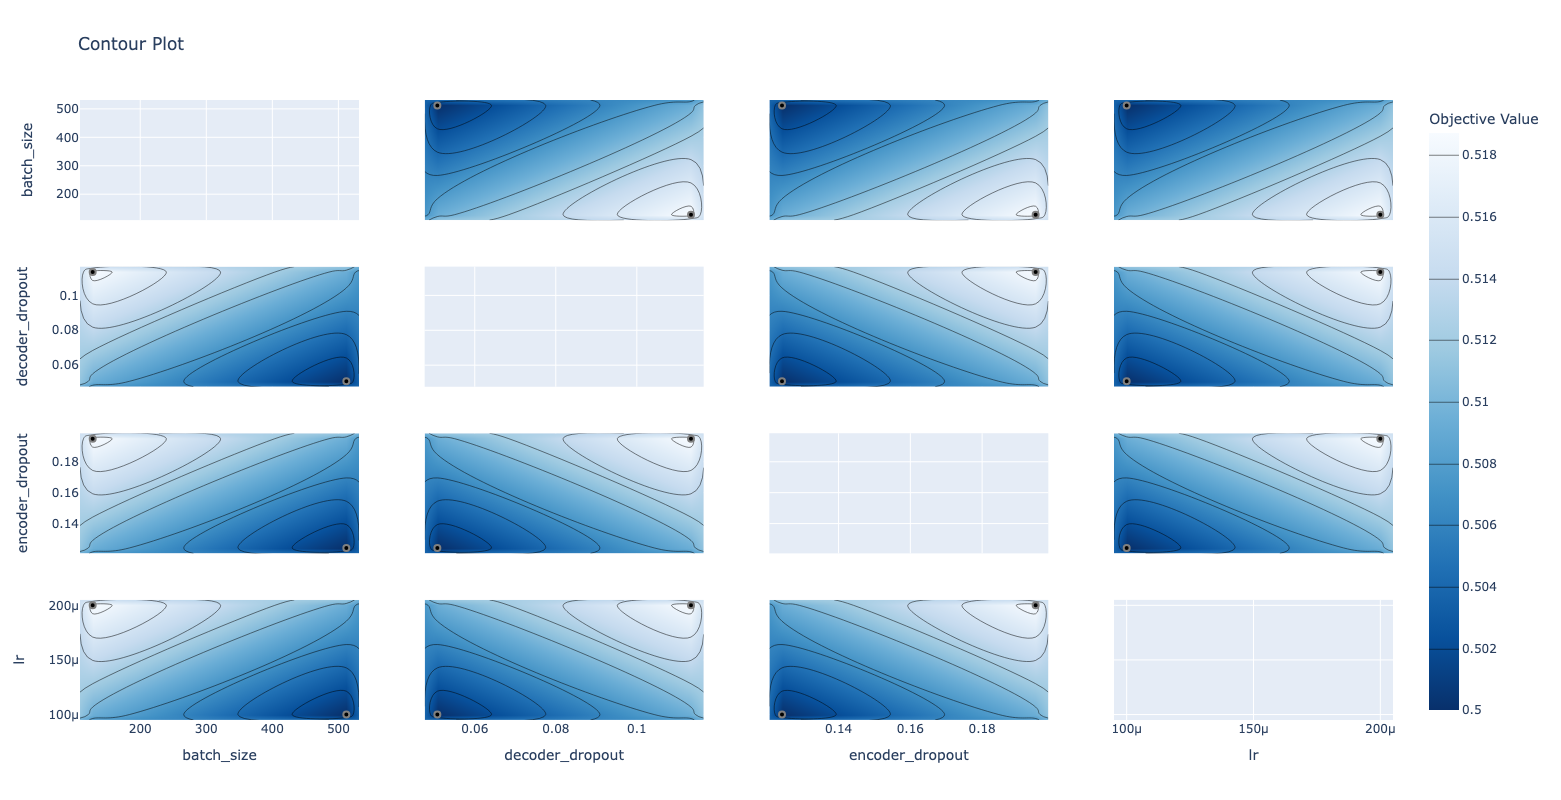

In [39]:
# Visualize hyperparameter relationships.
fig = plot_contour(study, params=['batch_size', 'lr', 'encoder_dropout', 'decoder_dropout'])
fig.update_layout(width=800, height=800)

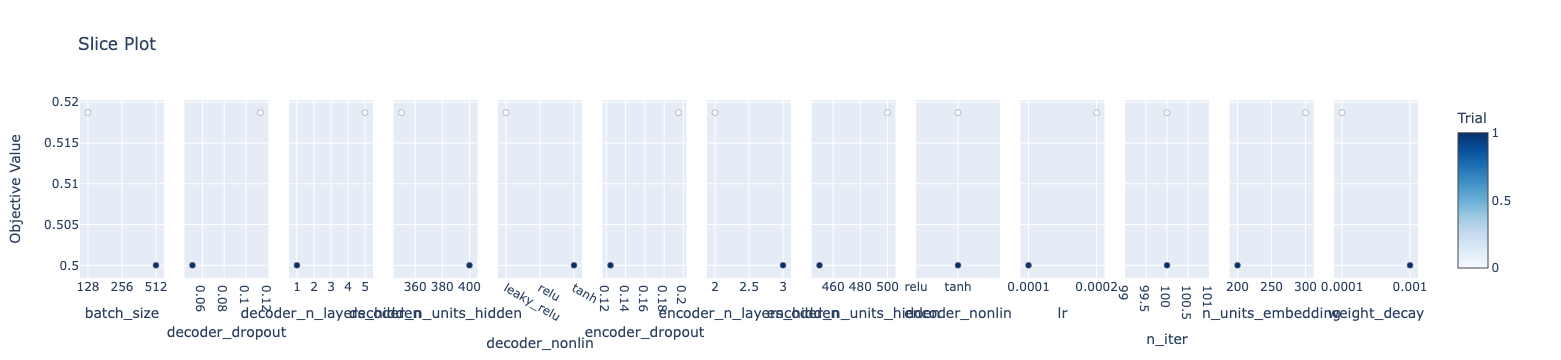

In [40]:
# Visualize individual hyperparameters as slice plot.
plot_slice(study)

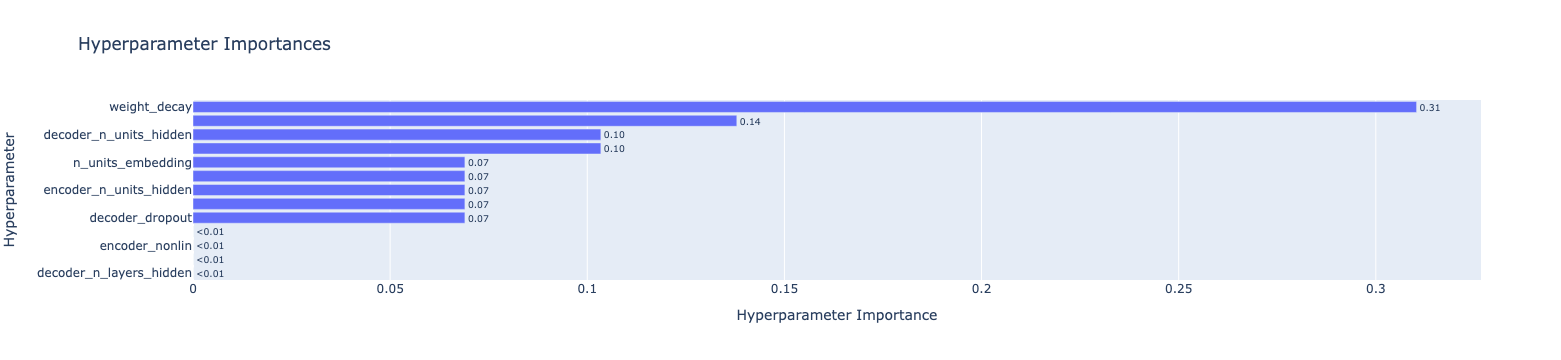

In [41]:
# Visualize parameter importances.
plot_param_importances(study)

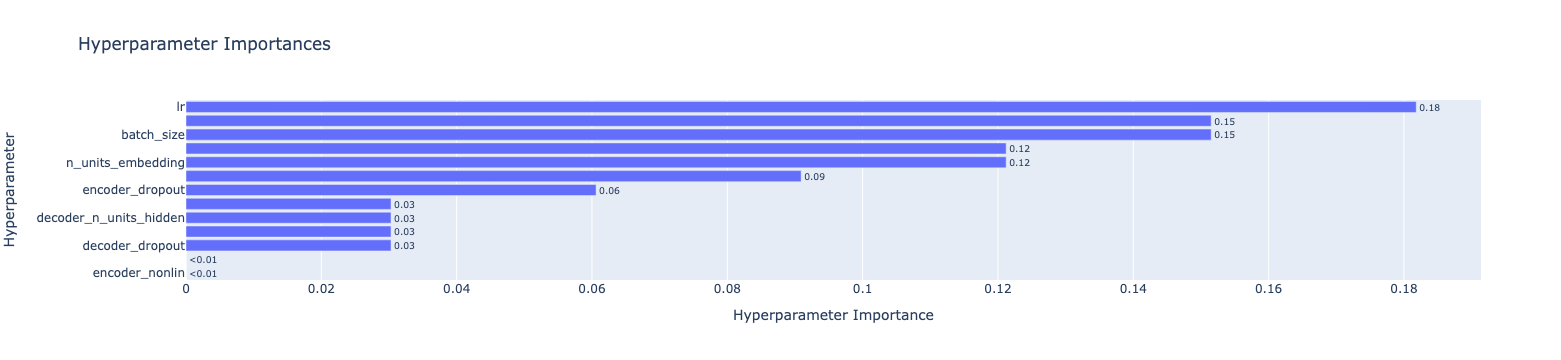

In [42]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

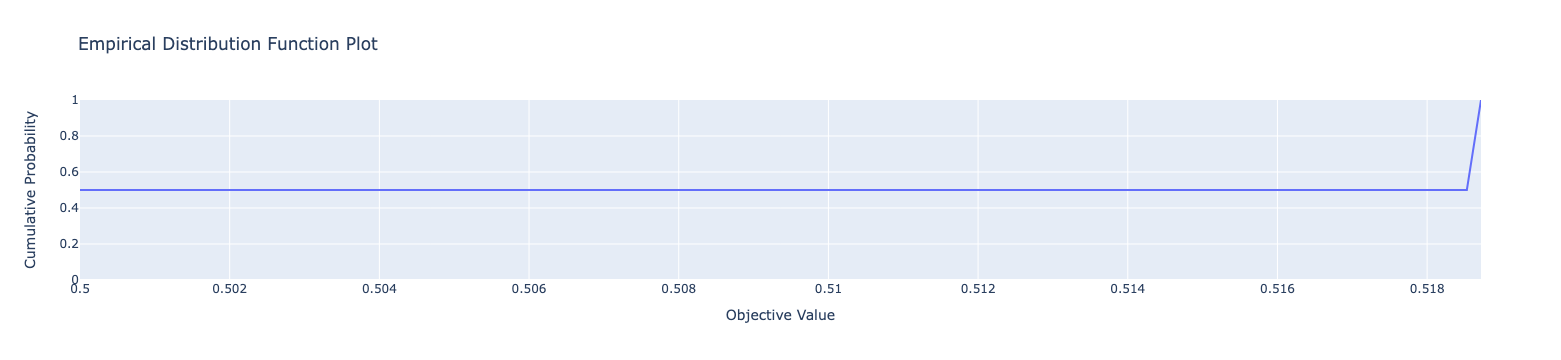

In [43]:
# Visualize empirical distribution function of the objective.
plot_edf(study)

In [ ]:
# best_params = study.best_params
# report = Benchmarks.evaluate(
#     [("test", PLUGIN, best_params)],
#     train_loader,
#     test_loader,
#     repeats=1,
#     metrics={"detection": ["detection_mlp", "detection_xgb"]},  # DELETE THIS LINE FOR ALL METRICS
# )
# Benchmarks.print(report)

## HyperImpute

In [44]:
# list of all available imputers
from hyperimpute.plugins.imputers import Imputers
imputers = Imputers()
imputers.list()

['ice',
 'sklearn_missforest',
 'EM',
 'miwae',
 'miracle',
 'gain',
 'mean',
 'softimpute',
 'most_frequent',
 'nop',
 'median',
 'mice',
 'sklearn_ice',
 'missforest',
 'sinkhorn',
 'hyperimpute']

In [ ]:
# using mean imputer
from hyperimpute.plugins.utils.simulate import simulate_nan
# helps to simulate nan based on the mechanisms available!

def ampute(x, mechanism, p_miss):
    x_simulated = simulate_nan(np.asarray(x), p_miss, mechanism)

    mask = x_simulated["mask"]
    x_miss = x_simulated["X_incomp"]

    return pd.DataFrame(x), pd.DataFrame(x_miss), pd.DataFrame(mask)

datasets = {}
headers = ["Plugin"]

pct = 0.3

# Missing Completely At Random (MCAR) if the probability of being missing is the same for all observations
# Missing At Random (MAR) if the probability of being missing only depends on observed values.
# Missing Not At Random (MNAR) if the unavailability of the data depends on both observed and unobserved data such as its value itself.
mechanisms = ["MAR", "MNAR", "MCAR"]
percentages = [pct]

plugins = ["mean"]

for ampute_mechanism in mechanisms:
    for p_miss in percentages:
        if ampute_mechanism not in datasets:
            datasets[ampute_mechanism] = {}

        headers.append(ampute_mechanism + "-" + str(p_miss))
        datasets[ampute_mechanism][p_miss] = ampute(X_train, ampute_mechanism, p_miss)

In [ ]:
import time
from tqdm import tqdm
from hyperimpute.plugins.utils.metrics import RMSE

results = []
duration = []

print(datasets)

for plugin in tqdm(plugins):
    plugin_results = [plugin]
    plugin_duration = [plugin]

    for ampute_mechanism in mechanisms:
        for p_miss in percentages:
            ctx = imputers.get(plugin)
            #print(datasets[ampute_mechanism][p_miss])
            x, x_miss, mask = datasets[ampute_mechanism][p_miss]
            start = time.time() * 1000
            x_imp = ctx.fit_transform(x_miss)

            plugin_duration.append(round(time.time() * 1000 - start, 4))
            plugin_results.append(RMSE(x_imp.values, x.values, mask.values))

    results.append(plugin_results)
    duration.append(plugin_duration)

In [ ]:
# display 
from IPython.display import HTML, display
import tabulate

# results - RMSE; lower is better
display(HTML(tabulate.tabulate(results, headers=headers, tablefmt="html")))

# duration taken
display(HTML(tabulate.tabulate(duration, headers=headers, tablefmt="html")))

In [ ]:
# get more metrics to compare using xgboost

from sklearn import metrics
import xgboost as xgb

def get_metrics(X_train, y_train, X_test, y_test):
    xgb_clf = xgb.XGBClassifier(verbosity=0)
    xgb_clf = xgb_clf.fit(X_train, y_train)

    y_pred = xgb_clf.predict(X_test)

    score = xgb_clf.score(X_test, y_test)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auroc = metrics.auc(fpr, tpr)

    prec, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
    aurpc = metrics.auc(recall, prec)

    return score, auroc, aurpc


metrics_headers = ["Plugin", "Accuracy", "AUROC", "AURPC"]
xgboost_test_score = []


x, x_miss, mask = datasets["MAR"][pct]

xgboost_test_score.append(
    ["original dataset", *get_metrics(X_train, y_train, X_test, y_test)]
)
# : accuracy, area under the ROC curve (AUROC), and area under the precision-recall curve (AURPC).
for plugin in plugins:
    X_train_imp = imputers.get(plugin).fit_transform(x_miss.copy())
    # run on impute data
    score, auroc, aurpc = get_metrics(X_train_imp, y_train, X_test, y_test)
    xgboost_test_score.append([plugin, score, auroc, aurpc])

In [ ]:
# the higher the better
display(
    HTML(
        tabulate.tabulate(xgboost_test_score, headers=metrics_headers, tablefmt="html")
    )
)

## Metrics

In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def distance_to_closest_records(synthetic_data, real_data):
    distances = euclidean_distances(synthetic_data, real_data)
    min_distances = np.min(distances, axis=1)
    return min_distances

# Example usage
synthetic_data = pd.DataFrame({
    'Feature1': [0.5, 0.2, 0.9],
    'Feature2': [0.8, 0.4, 0.1]
})

real_data = pd.DataFrame({
    'Feature1': [0.6, 0.3, 0.8],
    'Feature2': [0.7, 0.5, 0.2]
})

# Convert categorical features to numeric using one-hot encoding
synthetic_data = pd.get_dummies(synthetic_data)
real_data = pd.get_dummies(real_data)

synthetic_array = synthetic_data.to_numpy()
real_array = real_data.to_numpy()

distances = distance_to_closest_records(synthetic_array, real_array)
print("Distance to closest real records:", distances)

Distance to closest real records: [0.14142136 0.14142136 0.14142136]


In [47]:
import numpy as np
from scipy.stats import iqr

def outlier_coverage_score(real_data, synthetic_data):
    # Calculate IQR for real data
    q1_real = real_data.quantile(0.25)
    q3_real = real_data.quantile(0.75)
    iqr_real = q3_real - q1_real
    
    # Define outlier ranges for real data
    lower_bound_real = q1_real - 1.5 * iqr_real
    upper_bound_real = q3_real + 1.5 * iqr_real
    
    # Count outliers in real data
    real_outliers = real_data[(real_data < lower_bound_real) | (real_data > upper_bound_real)]
    num_real_outliers = len(real_outliers)
    
    # Calculate IQR for synthetic data
    q1_synthetic = synthetic_data.quantile(0.25)
    q3_synthetic = synthetic_data.quantile(0.75)
    iqr_synthetic = q3_synthetic - q1_synthetic
    
    # Define outlier ranges for synthetic data
    lower_bound_synthetic = q1_synthetic - 1.5 * iqr_synthetic
    upper_bound_synthetic = q3_synthetic + 1.5 * iqr_synthetic
    
    # Count outliers in synthetic data within the real outlier ranges
    synthetic_outliers = synthetic_data[(synthetic_data >= lower_bound_real) & (synthetic_data <= upper_bound_real)]
    num_synthetic_outliers = len(synthetic_outliers)
    
    # Calculate the coverage score
    coverage_score = num_synthetic_outliers / num_real_outliers if num_real_outliers > 0 else 0.0
    return coverage_score

# Example usage
real_data = pd.Series([10, 15, 20, 25, 30, 200])  # Example real data with an outlier (200)
synthetic_data = pd.Series([12, 14, 18, 22, 27, 28])  # Example synthetic data

score = outlier_coverage_score(real_data, synthetic_data)
print("Outlier Coverage Score:", score)


Outlier Coverage Score: 6.0


In [48]:
import numpy as np
from scipy.stats import iqr

def outlier_coverage_score(real_data, synthetic_data):
    # Calculate IQR for real data
    q1_real, q3_real = real_data.quantile([0.25, 0.75])
    iqr_real = q3_real - q1_real
    
    # Define outlier ranges for real data
    lower_bound_real = q1_real - 1.5 * iqr_real
    upper_bound_real = q3_real + 1.5 * iqr_real
    
    # Count outliers in real data
    real_outliers = real_data[(real_data < lower_bound_real) | (real_data > upper_bound_real)]
    num_real_outliers = len(real_outliers)
    total_real_points = len(real_data)
    
    # Calculate IQR for synthetic data
    q1_synthetic, q3_synthetic = synthetic_data.quantile([0.25, 0.75])
    iqr_synthetic = q3_synthetic - q1_synthetic
    
    # Define outlier ranges for synthetic data
    lower_bound_synthetic = q1_synthetic - 1.5 * iqr_synthetic
    upper_bound_synthetic = q3_synthetic + 1.5 * iqr_synthetic
    
    # Count outliers in synthetic data within the real outlier ranges
    synthetic_outliers = synthetic_data[(synthetic_data >= lower_bound_real) & (synthetic_data <= upper_bound_real)]
    num_synthetic_outliers = len(synthetic_outliers)
    total_synthetic_points = len(synthetic_data)
    
    # Calculate the coverage score
    p_real = num_real_outliers / total_real_points
    p_synthetic = num_synthetic_outliers / total_synthetic_points
    score = min(p_synthetic / p_real, 1)
    
    return score

# Example usage
real_data = pd.Series([10, 15, 20, 5, 30, 200])  # Example real data with an outlier (200)
synthetic_data = pd.Series([12, 14, 10, 22, 20, 28])  # Example synthetic data

score = outlier_coverage_score(real_data, synthetic_data)
print("Normalized Outlier Coverage Score:", score)


Normalized Outlier Coverage Score: 1


In [49]:
import numpy as np
from scipy.stats import iqr

def calculate_num_outliers(data):
    q1, q3 = data.quantile([0.25, 0.75])
    iqr_value = q3 - q1
    
    print(q1, q3)
    
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    
    print(lower_bound, upper_bound)
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    # print("outliers ", q1, q3 , iqr_value, lower_bound, upper_bound)
    num_outliers = len(outliers)
    total_points = len(data)
    return num_outliers, total_points

def outlier_coverage_score(real_data, synthetic_data):
    num_real_outliers, total_real_points = calculate_num_outliers(real_data)
    num_synthetic_outliers, total_synthetic_points = calculate_num_outliers(synthetic_data)
    
    p_real = num_real_outliers / total_real_points
    p_synthetic = num_synthetic_outliers / total_synthetic_points
    score = min(p_synthetic / p_real, 1)
    
    return score

# Example usage
real_data = pd.Series([10, 15, 20, 25, -0.0009999999009999, 30, 200])  # Example real data with an outlier (200)
synthetic_data = pd.Series([12, 14, 18, 22, -0.9999, 27, 200])  # Example synthetic data

score = outlier_coverage_score(real_data, synthetic_data)
print("Normalized Outlier Coverage Score:", score)


12.5 27.5
-10.0 50.0
13.0 24.5
-4.25 41.75
Normalized Outlier Coverage Score: 1.0


In [50]:
import pandas as pd

# Example data
data = pd.Series([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Calculate different quantiles
q1 = data.quantile(0.25)  # 25th percentile (Q1)
q2 = data.quantile(0.50)  # 50th percentile (median)
q3 = data.quantile(0.75)  # 75th percentile (Q3)

print("Q1 (25th percentile):", q1)
print("Median (50th percentile):", q2)
print("Q3 (75th percentile):", q3)

Q1 (25th percentile): 32.5
Median (50th percentile): 55.0
Q3 (75th percentile): 77.5


In [51]:
import pandas as pd

# Example data
data = pd.Series([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Calculate and print the 25th percentile (Q1)
q1 = data.quantile(0.25)
print("Q1 (25th percentile):", q1)  

Q1 (25th percentile): 32.5


In [52]:
import numpy as np
from scipy.stats import iqr

def calculate_num_outliers(data):
    """
    Calculate the number of outliers in a dataset and the total number of data points.

    Parameters:
        data (pandas.Series): The input data for which to calculate outliers.

    Returns:
        num_outliers (int): Number of outliers in the dataset.
        total_points (int): Total number of data points in the dataset.
    """
    # Calculate the first and third quartiles
    q1, q3 = data.quantile([0.25, 0.75])
    # Calculate the interquartile range (IQR)
    iqr_value = q3 - q1
    
    # Calculate lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    
    # Identify outliers within the defined bounds
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    # Calculate the number of outliers and total data points
    num_outliers = len(outliers)
    total_points = len(data)
    
    return num_outliers, total_points

def outlier_coverage_score(real_data, synthetic_data):
    """
    Calculate the outlier coverage score between real and synthetic datasets.

    Parameters:
        real_data (pandas.Series): The real dataset containing outliers.
        synthetic_data (pandas.Series): The synthetic dataset to be evaluated.

    Returns:
        score (float): The outlier coverage score.
    """
    # Calculate the number of outliers and total data points for real data
    num_real_outliers, total_real_points = calculate_num_outliers(real_data)
    # Calculate the number of outliers and total data points for synthetic data
    num_synthetic_outliers, total_synthetic_points = calculate_num_outliers(synthetic_data)
    
    # Calculate the proportions of outliers
    p_real = num_real_outliers / total_real_points
    p_synthetic = num_synthetic_outliers / total_synthetic_points
    
    # Calculate the outlier coverage score
    score = min(p_synthetic / p_real, 1)
    
    return score

# Example usage
real_data = pd.Series([10, 15, 20, 25, -0.0009999999009999, 30, 200])  # Example real data with an outlier (200)
synthetic_data = pd.Series([12, 14, 18, 22, -0.9999, 27, 200])  # Example synthetic data

score = outlier_coverage_score(real_data, synthetic_data)
print("Normalized Outlier Coverage Score:", score)

Normalized Outlier Coverage Score: 1.0


In [53]:
import numpy as np
from scipy.stats import wasserstein_distance, entropy
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import MinMaxScaler

def compute_distance(data1, data2):
    """
    Compute the appropriate distance (Wasserstein or Jensen-Shannon) based on data type.

    Parameters:
        data1 (pandas.Series): The first dataset.
        data2 (pandas.Series): The second dataset.

    Returns:
        distance (float): The calculated distance.
    """
    if data1.dtype == "object":
        # Categorical data: Use Jensen-Shannon distance
        categories = data1.unique()
        real_counts = data1.value_counts()
        fake_counts = data2.value_counts()

        real_pdf = real_counts / len(data1)
        fake_pdf = fake_counts / len(data2)

        categories = real_pdf.index.tolist()
        real_pdf_values = real_pdf.values.tolist()
        fake_pdf_values = [fake_pdf.get(cat, 0) for cat in categories]
        
        print(real_pdf_values)
        print(type(fake_pdf_values), fake_pdf_values)

        js_distance = jensenshannon(real_pdf_values, fake_pdf_values, 2.0)
        return js_distance
    else:
        # Numerical data: Use Wasserstein distance
        scaler = MinMaxScaler()
        real_scaled = scaler.fit_transform(data1.values.reshape(-1, 1)).flatten()
        fake_scaled = scaler.transform(data2.values.reshape(-1, 1)).flatten()

        w_distance = wasserstein_distance(real_scaled, fake_scaled)
        return w_distance

# # Example usage
# real_data = pd.Series([...])  # Replace with your real data
# fake_data = pd.Series([...])  # Replace with your fake data

# distance = compute_distance(real_data, fake_data)
# print("Distance:", distance)


In [54]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import MinMaxScaler

def compute_distance(data1, data2):
    """
    Compute the appropriate distance (Wasserstein or Jensen-Shannon) based on data type.

    Parameters:
        data1 (pandas.Series): The first dataset.
        data2 (pandas.Series): The second dataset.

    Returns:
        distance (float): The calculated distance.
    """
    # Drop missing values
    data1_cleaned = data1.dropna()
    data2_cleaned = data2.dropna()

    if data1_cleaned.dtype == "object":
        # Categorical data: Use Jensen-Shannon distance
        categories = data1_cleaned.unique()
        real_counts = data1_cleaned.value_counts()
        fake_counts = data2_cleaned.value_counts()

        real_pdf = real_counts / len(data1_cleaned)
        fake_pdf = fake_counts / len(data2_cleaned)

        categories = real_pdf.index.tolist()
        real_pdf_values = real_pdf.values.tolist()
        fake_pdf_values = [fake_pdf.get(cat, 0) for cat in categories]

        js_distance = jensenshannon(real_pdf_values, fake_pdf_values, 2.0)
        return js_distance
    else:
        # Numerical data: Use Wasserstein distance
        scaler = MinMaxScaler()
        real_scaled = scaler.fit_transform(data1_cleaned.values.reshape(-1, 1)).flatten()
        fake_scaled = scaler.transform(data2_cleaned.values.reshape(-1, 1)).flatten()

        w_distance = wasserstein_distance(real_scaled, fake_scaled)
        return w_distance

# # Example usage
# categorical_data = pd.Series(["A", "B", "A", np.nan, "B", "C"])
# numerical_data = pd.Series([10, 20, 15, 25, 18, np.nan])

# categorical_distance = compute_distance(categorical_data, categorical_data)
# numerical_distance = compute_distance(numerical_data, numerical_data)

# print("Categorical Distance:", categorical_distance)
# print("Numerical Distance:", numerical_distance)


In [55]:

# Define example data
categorical_data = pd.Series(["m", "D", np.nan, "A", "C", "B", "C"])
categorical_data2 = pd.Series(["A", "A", "A", "B", "B", "C"])
numerical_data = pd.Series([10, 20, 15, 25, np.nan, 18, 30])
numerical_data2 = pd.Series([40, 21, 20, 25, 18, 30])

# Test categorical distance
categorical_distance = compute_distance(categorical_data, categorical_data2)
print("Categorical Distance:", categorical_distance)

# Test numerical distance
numerical_distance = compute_distance(numerical_data, numerical_data2)
print("Numerical Distance:", numerical_distance)


Categorical Distance: 0.5200250392878958
Numerical Distance: 0.3
